## Imports and utils

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool
import warnings
from tqdm import tqdm_notebook

warnings.filterwarnings("ignore")

In [2]:
seed = 3422

In [3]:
def make_submission(tst_df, preds, name):
    tst_df['NTG'] = preds
    tst_df.to_csv('submission_' + name +'.csv', index=False)

## Feature engeneering using KNN

In [4]:
class NearestNeighborsFeats(BaseEstimator, ClassifierMixin):
    '''
        This class should implement KNN features extraction 
    '''
    def __init__(self, n_jobs, k_list, metric, n_classes=None, n_neighbors=None, eps=1e-6):
        self.n_jobs = n_jobs
        self.k_list = k_list
        self.metric = metric
        
        if n_neighbors is None:
            self.n_neighbors = max(k_list) 
        else:
            self.n_neighbors = n_neighbors
            
        self.eps = eps        
        self.n_classes_ = n_classes
    
    def fit(self, X, y):
        '''
            Set's up the train set and self.NN object
        '''
        self.NN = NearestNeighbors(n_neighbors=max(self.k_list), 
                                      metric=self.metric, 
                                      n_jobs=1, 
                                      algorithm='brute' if self.metric=='cosine' else 'auto')
        self.NN.fit(X)
        
        self.y_train = y
        self.X = X
        
        self.n_classes = np.unique(y).shape[0] if self.n_classes_ is None else self.n_classes_
        
        
    def predict(self, X, train=False):       
        '''
            Produces KNN features for every object of a dataset X
        '''
        if self.n_jobs == 1:
            test_feats = []
            for i in range(X.shape[0]):
                test_feats.append(self.get_features_for_one(X[i:i+1], train=train))
        else:
            with Pool(self.n_jobs) as p:
                test_feats = p.map(self.get_features_for_one, list(X))
            
        return np.vstack(test_feats)
        
        
    def get_features_for_one(self, x, train=False):
        '''
            Computes KNN features for a single object `x`
        '''
        train = int(train)

        NN_output = self.NN.kneighbors(x)
        neighs = NN_output[1][0]
        
        neighs_dist = NN_output[0][0] 

        neighs_y = self.y_train[neighs]
        return_list = [] 
        
        return_list += [[neighs_y[train], neighs_dist[train]]]
        
        for k in self.k_list:
            
            feature_list = []
            feature_list += [neighs_dist[k - 1]]
            feature_list += [neighs_dist[k - 1] / (neighs_dist[0] + self.eps)]
            feature_list += [np.mean(neighs_dist[train:k])]
            feature_list += [np.mean(neighs_y[train:k])]
            feature_list += [neighs_y[k - 1]]
            feature_list += [np.log(neighs_dist[k - 1]) * neighs_y[k - 1]]
            feature_list += [neighs_dist[k - 1] * neighs_y[k - 1]]
            feature_list += [neighs_y[k - 1] / neighs_dist[k - 1]]
            feature_list += list(np.mean(np.array(self.X[neighs[train:k]] - np.array(x[0])) * np.array([neighs_y[train:k]]).T, axis=0))
            feature_list += list(np.mean(np.array(self.X[neighs[train:k]] - np.array(x[0]) + self.eps) / np.array([neighs_y[train:k]]).T, axis=0))
            feature_list += list(np.mean(np.array(self.X[neighs[train:k]]) * np.array([neighs_y[train:k]]).T, axis=0))
            feature_list += list(np.mean(np.array(self.X[neighs[train:k]]) / np.array([neighs_y[train:k]]).T, axis=0))
 
            return_list += [feature_list]        
        
        knn_feats = np.hstack(return_list)
        
        return knn_feats

In [5]:
trn_df = pd.read_csv('Training_wells.csv')
tst_df = pd.read_csv('Empty_part.csv')

In [6]:
k_list = [2, 5, 9]
new_tst_df = tst_df.copy()
new_trn_df = trn_df.copy()
    
for metric in ['minkowski', 'cosine', 'manhattan', 'euclidean']:
    print (metric)
    
    NNF = NearestNeighborsFeats(n_jobs=1, k_list=k_list, metric=metric)
    NNF.fit(trn_df[trn_df.columns.drop(['NTG', 'Well'])].values, trn_df['NTG'].values)

    test_knn_feats = NNF.predict(tst_df[tst_df.columns.drop(['Well'])].values)
    test_knn_feats_df = pd.DataFrame(test_knn_feats, columns=[metric + '_feature' + str(x) for x in range(test_knn_feats.shape[1])])
    new_tst_df = pd.concat([new_tst_df, test_knn_feats_df], axis=1)
    
    train_knn_feats = NNF.predict(trn_df[trn_df.columns.drop(['Well', 'NTG'])].values, train=True)
    train_knn_feats_df = pd.DataFrame(train_knn_feats, columns=[metric + '_feature' + str(x) for x in range(test_knn_feats.shape[1])])
    new_trn_df = pd.concat([new_trn_df, train_knn_feats_df], axis=1)

minkowski
cosine
manhattan
euclidean


In [7]:
new_tst_df = new_tst_df.sort_values('Well')

## Leave one out as validation

In [8]:
saved_results = {}

def leave_one_out_validation(data, model, m, description='common', save_res=False, **kwargs):
    global saved_results
    
    k_list = [2, 5, 9]
    result = []
    
    for index, row in tqdm_notebook(data.iterrows()):
        new_data = data.copy()
        new_data.drop(columns=['Well'], inplace=True)
        new_test = new_data.loc[[index], :].copy()
        new_data = new_data.drop(index=index)
        new_train_data = new_data.copy()
        new_test_data = new_test.copy()
        new_train_data.reset_index(drop=True, inplace=True)
        new_test_data.reset_index(drop=True, inplace=True)

        for metric in ['minkowski', 'cosine', 'manhattan', 'euclidean']:
            NNF = NearestNeighborsFeats(n_jobs=1, k_list=k_list, metric=metric)
            NNF.fit(new_data[new_data.columns.drop(['NTG'])].values, new_data['NTG'].values)

            test_knn_feats = NNF.predict(new_test[new_test.columns.drop(['NTG'])].values)
            test_knn_feats_df = pd.DataFrame(test_knn_feats, columns=[metric + '_feature' + str(x) for x in range(test_knn_feats.shape[1])])
            new_test_data = pd.concat([new_test_data, test_knn_feats_df], axis=1)

            train_knn_feats = NNF.predict(new_data[new_data.columns.drop(['NTG'])].values, train=True)
            train_knn_feats_df = pd.DataFrame(train_knn_feats, columns=[metric + '_feature' + str(x) for x in range(test_knn_feats.shape[1])])
            new_train_data = pd.concat([new_train_data, train_knn_feats_df], axis=1)
        
        model.fit(new_train_data[new_train_data.columns.drop(['NTG'])], new_train_data['NTG'], **kwargs)
        
        pred = model.predict(new_test_data[new_test_data.columns.drop(['NTG'])])
        result.append(pred[0])
        
    m_value = m(data.NTG.values, result)
    
    if save_res:
        if description not in saved_results:
            saved_results[description] = (None, 1e3)
        if m_value < saved_results[description][1]:
            saved_results[description] = (result, m_value)
    
    print(m_value)
    return m_value

## Function to plot results

In [9]:
size = (tst_df['Y'].max() - tst_df['Y'].min() + 1, tst_df['X'].max() - tst_df['X'].min() + 1)

In [10]:
def plot_stuff(preds):    
    a = np.zeros(size)
    for i, x in enumerate(tst_df.values):
        a[x[2] - tst_df.Y.min(), x[1] - tst_df.X.min()] = preds[i]

    for i, x in enumerate(trn_df.values):
        a[x[2] - trn_df.Y.min(), x[1] - trn_df.X.min()] = x[3]

    plt.figure(figsize=(9,9))
    plt.imshow(a)
    plt.show()

## Models

In [11]:
from sklearn import linear_model, neighbors, pipeline, model_selection, preprocessing, metrics, impute, feature_selection

def linear_pipeline(trn_df, tst_df, target='NTG', use='lasso'):
    if use == 'lasso':
        l = linear_model.LassoCV()
    elif use == 'ridge':
        l = linear_model.RidgeCV(alphas=np.linspace(start=0.1, stop=10, num=1000), normalize=True)
    elif use == 'elasticnet':
        l = linear_model.ElasticNetCV()
    elif use == 'linear':
        l = linear_model.LinearRegression()
    else:
        raise RuntimeError('Wrong model name')
    
    model = pipeline.Pipeline([
        ("fill_nan", impute.SimpleImputer(missing_values=np.nan, strategy='mean')), 
        ('scaler', preprocessing.StandardScaler()),
        ("select features", feature_selection.VarianceThreshold()),
        ('linear_model', l)]
    )
    
    model.fit(trn_df[trn_df.columns.drop(target)], trn_df[target])
    return model.predict(tst_df[trn_df.columns.drop(target)]), model

In [12]:
from sklearn.neighbors import KNeighborsRegressor

def KNN_pipline(trn_df, tst_df, target='NTG', k=2, metric='minkowski'):
    model = KNeighborsRegressor(k, metric=metric)
    model.fit(trn_df[trn_df.columns.drop(target)], trn_df[target])
    return model.predict(tst_df[trn_df.columns.drop(target)]), model

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

def random_forest_pipline(trn_df, tst_df, target='NTG', **kwargs):
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 2)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 20, num = 2)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 3, 4, 5, 8, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 3, 4, 5]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor(random_state=seed)
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1, random_state=seed)
    # Fit the random search model
    rf_random.fit(trn_df[trn_df.columns.drop(target)], trn_df[target])

    
    model = RandomForestRegressor(**rf_random.best_params_, random_state=seed)
    model.fit(trn_df[trn_df.columns.drop(target)], trn_df[target])
    return model.predict(tst_df[trn_df.columns.drop(target)]), model

In [14]:
from catboost import CatBoostRegressor

def catboost_pipeline(trn_df, tst_df, target='NTG', **kwargs):
    model = CatBoostRegressor(iterations=200, 
                              learning_rate=0.1,
                              depth=4,
                              l2_leaf_reg=1,
                              min_data_in_leaf=3,
                              rsm=0.5,
                              early_stopping_rounds=5,
                              random_state=seed
                             )
    
    model.fit(trn_df[trn_df.columns.drop(target)], trn_df[target], **kwargs)
    
    return model.predict(tst_df[trn_df.columns.drop(target)]), model

## Ensemble

In [15]:
trn_df = pd.read_csv('Training_wells.csv')
tst_df = pd.read_csv('Empty_part.csv')
 
def smart_ensemble(*preds):
    global trn_df, tst_df
    
    meta_trn_df = pd.DataFrame(trn_df[['NTG', 'X', 'Y']])
    meta_tst_df = pd.DataFrame(tst_df[['X', 'Y']])
    
    max_x = int(meta_tst_df.X.max())
    max_y = int(meta_tst_df.Y.max())
    min_x = int(meta_tst_df.X.min())
    min_y = int(meta_tst_df.Y.min())
    
    cnt = 0
    
    for p in preds:
        a = np.zeros(size)
        for i, x in enumerate(tst_df.values):
            a[x[2] - tst_df.Y.min(), x[1] - tst_df.X.min()] = p[i]
 
        for i, x in enumerate(trn_df.values):
            a[x[2] - trn_df.Y.min(), x[1] - trn_df.X.min()] = x[3]
 
        for add_x, add_y in [(x, y) for x in [-2, -1, 0, 1, 2] for y in [-2, -1, 0, 1, 2]]:
            meta_trn_df['smart_feature_' + str(cnt)] = 0
            for index, row in meta_trn_df.iterrows():
                new_x = int(row['X'] + add_x)
                new_y = int(row['Y'] + add_y)
            
                if max_x < new_x or min_x > new_x or max_y < new_y or min_y > new_y:
                    meta_trn_df.loc[index, 'smart_feature_' + str(cnt)] = a[int(row['Y']) - min_y, int(row['X']) - min_x]
                else:
                    meta_trn_df.loc[index, 'smart_feature_' + str(cnt)] = a[new_y - min_y, new_x - min_x]
 
            meta_tst_df['smart_feature_' + str(cnt)] = 0
            for index, row in meta_tst_df.iterrows():
                new_x = int(row['X'] + add_x)
                new_y = int(row['Y'] + add_y)
                
                if max_x < new_x or min_x > new_x or max_y < new_y or min_y > new_y:
                    meta_tst_df.loc[index, 'smart_feature_' + str(cnt)] = a[int(row['Y']) - min_y, int(row['X']) - min_x]
                else:
                    meta_tst_df.loc[index, 'smart_feature_' + str(cnt)] = a[new_y - min_y, new_x - min_x]
            cnt += 1
    
    
    model = CatBoostRegressor(iterations=200, 
                              learning_rate=0.1,
                              depth=3,
                              rsm=0.5,
                              l2_leaf_reg=1,
                              min_data_in_leaf=3,
                              early_stopping_rounds=5,
                              random_state=seed
                             )
    
    model.fit(meta_trn_df[meta_trn_df.columns.drop('NTG')], meta_trn_df['NTG'], silent=True)
    
    return model.predict(meta_tst_df[meta_trn_df.columns.drop('NTG')]), model

## Training

In [16]:
best_pred = None
best_rmse = 1e3

def find_best(preds, rmse_score):
    global best_pred, best_rmse
    
    if rmse_score < best_rmse:
        best_pred = preds
        best_rmse = rmse_score

In [17]:
predictions = []


0.058703217242967516
lasso
val RMSE:  0.058703217242967516


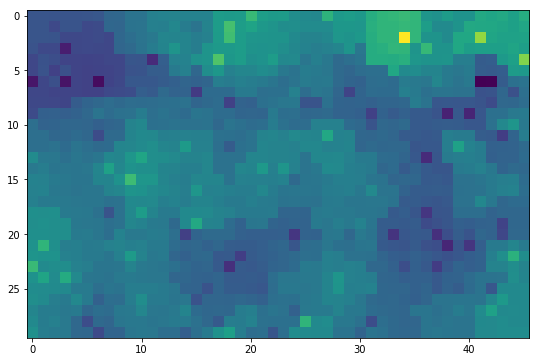


0.06037823633718426
ridge
val RMSE:  0.06037823633718426


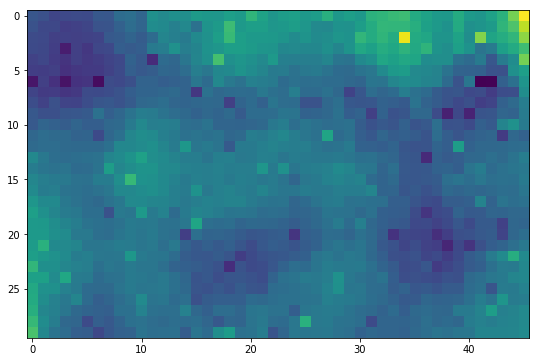

In [18]:
for i in ['lasso', 'ridge']:
    pred, model = linear_pipeline(new_trn_df[new_trn_df.columns.drop(['Well'])], new_tst_df, use=i)
    val_rmse = leave_one_out_validation(trn_df, model, lambda x,y: np.sqrt(metrics.mean_squared_error(x, y)))
    print(i)
    print('val RMSE: ', val_rmse)
    find_best(pred, val_rmse)
    plot_stuff(pred)
    predictions.append((pred, val_rmse, i))
    make_submission(tst_df, pred, i)


0.0838837238708129
K: 3
val RMSE:  0.0838837238708129


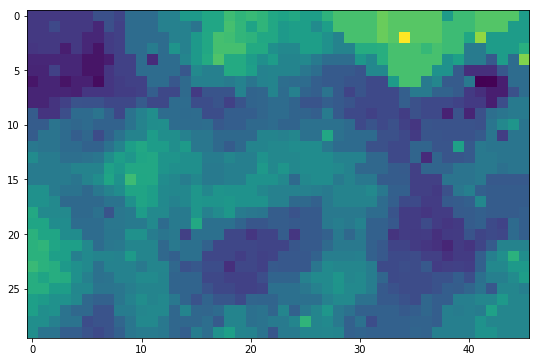


0.08108113151009007
K: 5
val RMSE:  0.08108113151009007


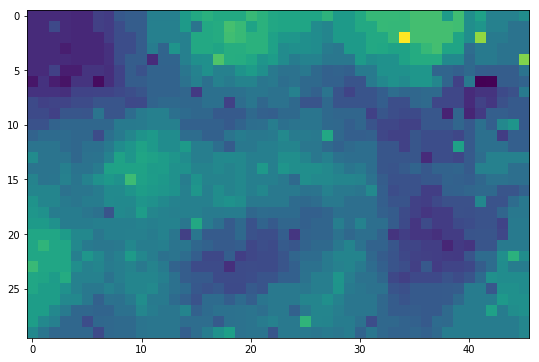


0.0838837238708129
K: 3
val RMSE:  0.0838837238708129


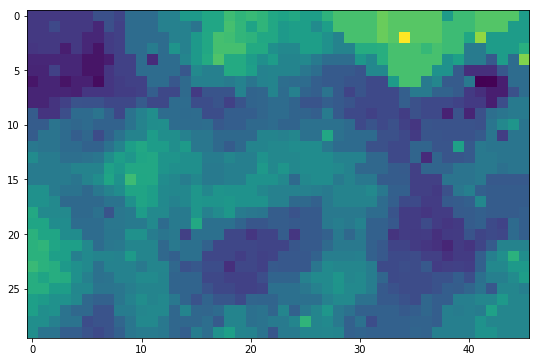


0.08108113151009007
K: 5
val RMSE:  0.08108113151009007


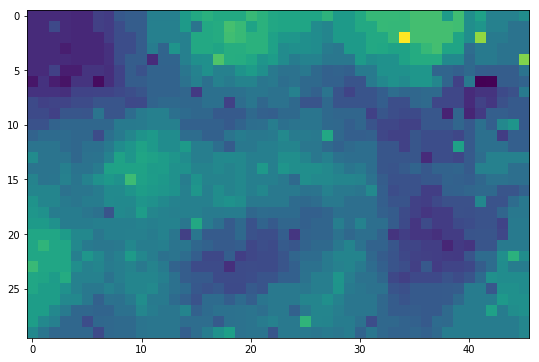

In [19]:
for m in ['minkowski', 'euclidean']:
    for k in [3, 5]:
        pred, model = KNN_pipline(trn_df[trn_df.columns.drop(['Well'])], tst_df, k=k, metric=m)
        val_rmse = leave_one_out_validation(trn_df, model, lambda x,y: np.sqrt(metrics.mean_squared_error(x, y)))
        print('K: ' + str(k))
        print('val RMSE: ', val_rmse)
        plot_stuff(pred)
        find_best(pred, val_rmse)
        predictions.append((pred, val_rmse, 'knn'))
        make_submission(tst_df, pred, 'knn_' + str(k))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.7s finished



0.06524478783353857
val RMSE:  0.06524478783353857


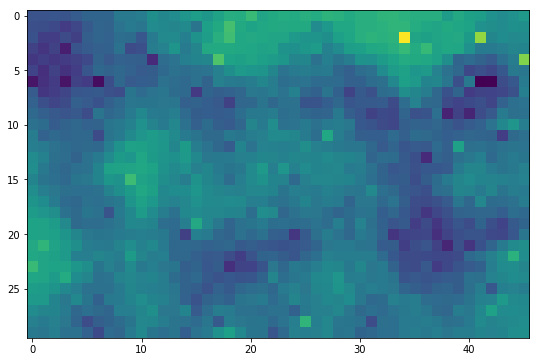

In [20]:
pred, model = random_forest_pipline(new_trn_df[new_trn_df.columns.drop(['Well'])], new_tst_df)
val_rmse = leave_one_out_validation(trn_df, model, lambda x,y: np.sqrt(metrics.mean_squared_error(x, y)))
print('val RMSE: ', val_rmse)
plot_stuff(pred)
find_best(pred, val_rmse)
predictions.append((pred, val_rmse, 'random_forest'))
make_submission(tst_df, pred, 'rand_f')


0.06493734769021603
val RMSE:  0.06493734769021603


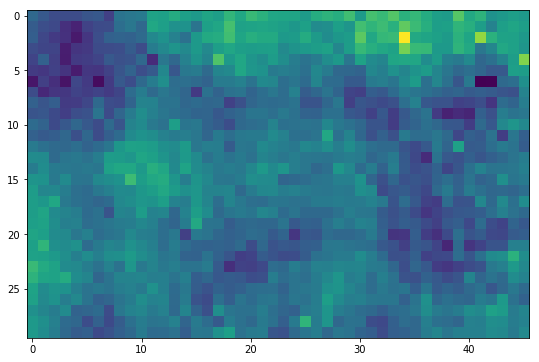

In [21]:
pred, model = catboost_pipeline(new_trn_df[new_trn_df.columns.drop(['Well'])], new_tst_df, silent=True)
val_rmse = leave_one_out_validation(trn_df, model, lambda x,y: np.sqrt(metrics.mean_squared_error(x, y)), silent=True)
print('val RMSE: ', val_rmse)
plot_stuff(pred)
find_best(pred, val_rmse)
predictions.append((pred, val_rmse, 'catboost'))
make_submission(tst_df, pred, 'catboost')

In [22]:
predictions

[(array([0.27871993, 0.27903643, 0.27798253, ..., 0.35956675, 0.35932125,
         0.36412632]), 0.058703217242967516, 'lasso'),
 (array([0.28275967, 0.27637022, 0.26819257, ..., 0.36424695, 0.36321941,
         0.36705566]), 0.06037823633718426, 'ridge'),
 (array([0.24123333, 0.24123333, 0.24123333, ..., 0.3544    , 0.3544    ,
         0.3544    ]), 0.0838837238708129, 'knn'),
 (array([0.22434, 0.22434, 0.22434, ..., 0.37076, 0.3538 , 0.3538 ]),
  0.08108113151009007,
  'knn'),
 (array([0.24123333, 0.24123333, 0.24123333, ..., 0.3544    , 0.3544    ,
         0.3544    ]), 0.0838837238708129, 'knn'),
 (array([0.22434, 0.22434, 0.22434, ..., 0.37076, 0.3538 , 0.3538 ]),
  0.08108113151009007,
  'knn'),
 (array([0.27560086, 0.27155181, 0.27385574, ..., 0.3615378 , 0.36566823,
         0.36827683]), 0.06524478783353857, 'random_forest'),
 (array([0.30663029, 0.28885138, 0.29196564, ..., 0.35050548, 0.34789143,
         0.35786782]), 0.06493734769021603, 'catboost')]

In [23]:
predictions_map = {}
for i in predictions:
    if i[2] not in predictions_map:
        predictions_map[i[2]] = (None, 0)
    if i[1] > predictions_map[i[2]][1]:
        predictions_map[i[2]] = (i[0], i[1])
predictions = [(x[1][0], x[1][1]) for x in predictions_map.items()] 

In [24]:
predictions = sorted(predictions, key=lambda x: x[1])

In [25]:
predictions

[(array([0.27871993, 0.27903643, 0.27798253, ..., 0.35956675, 0.35932125,
         0.36412632]), 0.058703217242967516),
 (array([0.28275967, 0.27637022, 0.26819257, ..., 0.36424695, 0.36321941,
         0.36705566]), 0.06037823633718426),
 (array([0.30663029, 0.28885138, 0.29196564, ..., 0.35050548, 0.34789143,
         0.35786782]), 0.06493734769021603),
 (array([0.27560086, 0.27155181, 0.27385574, ..., 0.3615378 , 0.36566823,
         0.36827683]), 0.06524478783353857),
 (array([0.24123333, 0.24123333, 0.24123333, ..., 0.3544    , 0.3544    ,
         0.3544    ]), 0.0838837238708129)]

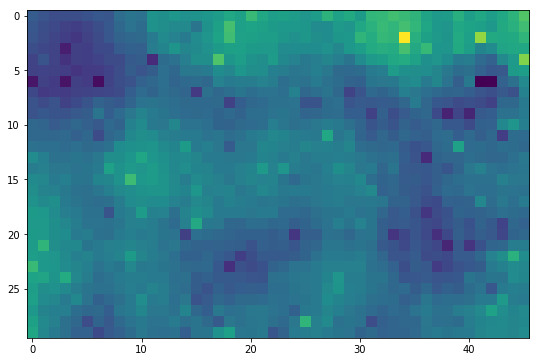

In [26]:
pred = predictions[0][0].copy()
n = 3
for i in range(1, n):
    pred += predictions[i][0]
pred /= n

plot_stuff(pred)
find_best(pred, 0.1)
make_submission(tst_df, pred, 'ensemble')

In [27]:
predictions_map

{'lasso': (array([0.27871993, 0.27903643, 0.27798253, ..., 0.35956675, 0.35932125,
         0.36412632]), 0.058703217242967516),
 'ridge': (array([0.28275967, 0.27637022, 0.26819257, ..., 0.36424695, 0.36321941,
         0.36705566]),
  0.06037823633718426),
 'knn': (array([0.24123333, 0.24123333, 0.24123333, ..., 0.3544    , 0.3544    ,
         0.3544    ]), 0.0838837238708129),
 'random_forest': (array([0.27560086, 0.27155181, 0.27385574, ..., 0.3615378 , 0.36566823,
         0.36827683]), 0.06524478783353857),
 'catboost': (array([0.30663029, 0.28885138, 0.29196564, ..., 0.35050548, 0.34789143,
         0.35786782]), 0.06493734769021603)}

In [28]:
predictions

[(array([0.27871993, 0.27903643, 0.27798253, ..., 0.35956675, 0.35932125,
         0.36412632]), 0.058703217242967516),
 (array([0.28275967, 0.27637022, 0.26819257, ..., 0.36424695, 0.36321941,
         0.36705566]), 0.06037823633718426),
 (array([0.30663029, 0.28885138, 0.29196564, ..., 0.35050548, 0.34789143,
         0.35786782]), 0.06493734769021603),
 (array([0.27560086, 0.27155181, 0.27385574, ..., 0.3615378 , 0.36566823,
         0.36827683]), 0.06524478783353857),
 (array([0.24123333, 0.24123333, 0.24123333, ..., 0.3544    , 0.3544    ,
         0.3544    ]), 0.0838837238708129)]

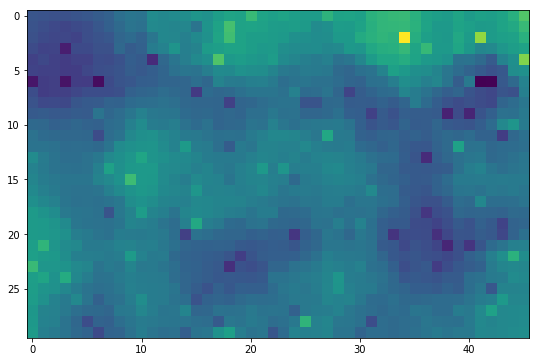

In [29]:
pred = predictions[0][0].copy()
n = 3
for i in [1, 3]:
    pred += predictions[i][0]
pred /= n

plot_stuff(pred)
find_best(pred, 0.0)
make_submission(tst_df, pred, 'ensemble_2')

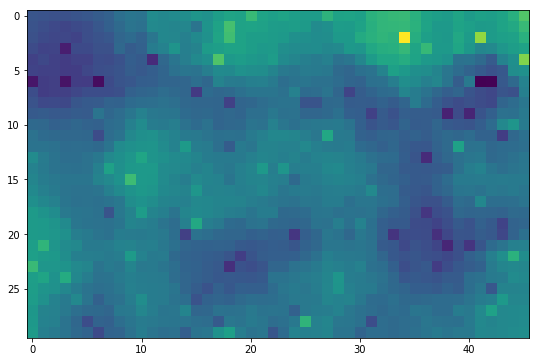

In [30]:
plot_stuff(best_pred)

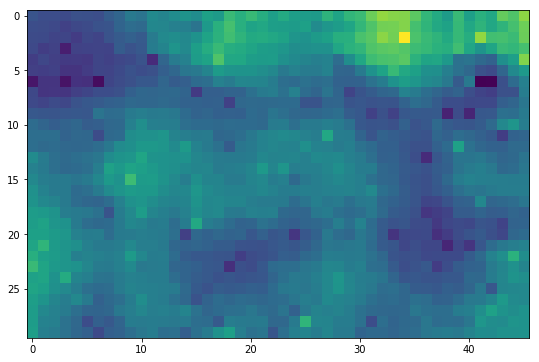

In [31]:
ensemble_pred, model = smart_ensemble(best_pred)
plot_stuff(ensemble_pred)
make_submission(tst_df, ensemble_pred, 'smart_ensemble1')

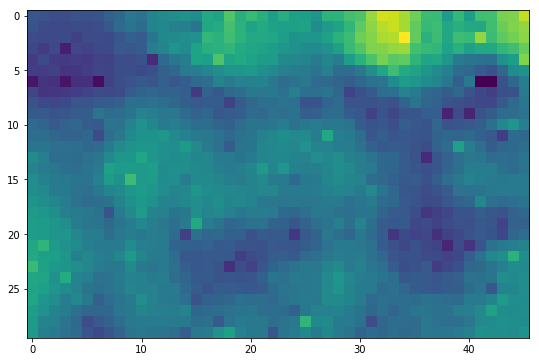

In [32]:
ensemble_pred, model = smart_ensemble(best_pred, ensemble_pred)
plot_stuff(ensemble_pred)
make_submission(tst_df, ensemble_pred, 'smart_ensemble2')